## Assignment 16 - Taxi Demand Prediction - Fourier Transforms

* Task 1: Incorporate Fourier features as features into Regression models and measure MAPE. <br>

* Task 2: Perform hyper-parameter tuning for Regression models.
        2a. Linear Regression: Grid Search
        2b. Random Forest: Random Search 
        2c. Xgboost: Random Search
* Task 3: Explore more time-series features using Google search/Quora/Stackoverflow to reduce the MAPE to < 12%

### Fourier Transforms Implementation - thought process and undestanding

* As we have 'ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1' which are number of pickups in the previous 5 bins (each bin is 10 minutes interval; 5 bins are 50 minute interval) bins for specific region.
* Now, plot x on time axis
* Also, number of pickups on y axis; it may number pf pickups in each second OR number of puckups in one minute interval OR number of pickups in 10 minute interval. I can decide any interval, here, we have number of pickups in 10 minute intervals are available
* Plot I'll get will be fourier plot from which I have to select top 1 OT top 2 OR top 3 OR top 5, both aplitudes and frequencies as fourier transformed features. So, pass the values (number of pickups) of decided intervals/bins (here we already have values for 5 bins ft_1 to ft_5) within 50 minutes interval to fft function, it will give frequency and amplitude representation, pick top number of f and a (sort f & a, take maximum peaks) as a features.


df_train_: 
    ft_5  ft_4  ft_3  ft_2  ft_1
4   137   135   129   150   164
Below are 5 complex numbers
Y:  [715.         +0.j           3.68033989+39.92412927j
 -18.68033989 -2.92641453j -18.68033989 +2.92641453j
   3.68033989-39.92412927j]
Here Y represents amplitude
Absolute values 5 complex numbers: 
[715.          40.09340344  18.90817284  18.90817284  40.09340344]
Absolute values first n/2 which is 2 complex numbers: 
[715.          40.09340344]
freq:  [ 0.   0.2  0.4 -0.4 -0.2]
Frequencies, first n/2 which is 2 complex numbers: 
[0.  0.2]

Here, looks like np.fft.fftfreq generated positive and negative frequency numbers and we consider only positive frequency numbers and respective amplitudes
Here, n/2 is 2 which 2, but we see 3 positive frequencies, its fine to consider 3 freqiencies and amplitudes

So, below can be my fourier features, both frequencies and amplitudes
frequency1, frequency2, frequency3 :  [0.  0.2 0.4]
amplitude1, amplitude2, amplitude3 :  [715.          40.09

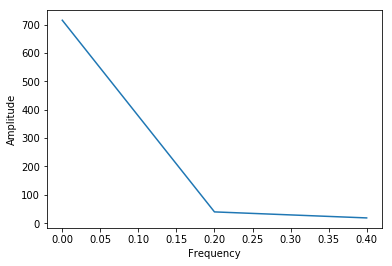

In [1]:
import pandas as pd
import numpy as np
### Fourier Transform undestanding
df_train__ = pd.read_csv("../input/df_train.csv")[0:100]
print("df_train_: \n",df_train__.filter(['ft_5','ft_4','ft_3','ft_2','ft_1'])[4:5])

n = 5 # We are passing total 5 bins
#Each row represent signal
signals = np.array(df_train__.filter(['ft_5','ft_4','ft_3','ft_2','ft_1'])[4:5], dtype=float)
Y = np.fft.fft(signals)
Y = Y.ravel()
print("Below are 5 complex numbers")
print("Y: ", Y)
print("Here Y represents amplitude")
print("Absolute values 5 complex numbers: ")
print(np.abs(Y)[:])
print("Absolute values first n/2 which is 2 complex numbers: ")
print(np.abs(Y)[:int(n/2)])

## We have 5 bins and each value represents 1 bin; So, n=5, timestep=1
#n = 5 # We are passing total 5 bins
#print("n: ",n)
timestep = 1 # one passed value represents one timestep or bin; 
# it may be the case that we are passing 10 values and 2 values represent 1 bin; 
# means 10 values represent 5 total bins, that means n is 5 and timestep is 2
freq = np.fft.fftfreq(n, d=timestep)
print("freq: ", freq)
print("Frequencies, first n/2 which is 2 complex numbers: ")
print(freq[:int(n/2)])

print("\nHere, looks like np.fft.fftfreq generated positive and negative frequency numbers and we consider only positive frequency numbers and respective amplitudes")
print("Here, n/2 is 2 which 2, but we see 3 positive frequencies, its fine to consider 3 freqiencies and amplitudes")

print("\nSo, below can be my fourier features, both frequencies and amplitudes")
print("frequency1, frequency2, frequency3 : ", freq[:3])
print("amplitude1, amplitude2, amplitude3 : ", np.abs(Y)[:3])

import matplotlib.pylab as plt
plt.figure()
#plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.plot( freq[:3], np.abs(Y)[:3] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

### Fourier Transform Implementation

In [2]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import f1_score, classification_report, log_loss
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.calibration import CalibratedClassifierCV
#np.set_printoptions(supress=True) 
from sklearn.metrics import mean_absolute_error

In [3]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [4]:
#import tsfresh.feature_extraction.settings.EfficientFCParameters as EfficientFCParameters


#### Functions 

In [5]:
def get_fourier_transform(signal, total_bins = 5, num_of_values_representing_one_bin = 1):
    n = 5
    freq = np.fft.fftfreq(total_bins, d=num_of_values_representing_one_bin)    
    #end_freq_index = 3 # Since 3 positive values - HARDCODED; int(n/2)+1 = 3
    top_freq = freq[:int(n/2)+1]
    
    #print("signal: ",signal)
    #print("Processing total ", total_bins , "bins")
    #print(num_of_values_representing_one_bin, " value's represent one bin")
    
    signal = np.array(signal, dtype=float)
    Y = np.fft.fft(signal)
    Y = np.abs(Y)
    Y = Y.ravel()    
     
    top_amplitude = Y[:int(n/2)+1]
    
    #print("top_freq: ", top_freq)
    #print("top_amplitude: ", top_amplitude)
    
    af = list(np.concatenate((top_freq, top_amplitude), axis=0))
        
    return af

def get_df(fourier_transforms, cols):
    df = pd.DataFrame(fourier_transforms)
    df.columns=cols    
    return df

#### Dataset

In [6]:
df_train_ = pd.read_csv("../input/df_train.csv")[0:200000]
df_test_ = pd.read_csv("../input/df_test.csv")

df_train_['id'] = np.arange(0,df_train_.shape[0])
df_test_['id']  = np.arange(0,df_test_.shape[0])

df_train_['time'] = np.arange(0,df_train_.shape[0])
df_test_['time']  = np.arange(0,df_test_.shape[0])

print("df_train_: \n",df_train_.head(2))
print("df_test_: \n",df_test_.head(2))

df_train_: 
    ft_5  ft_4  ft_3  ft_2  ft_1  ...   weekday  exp_avg   ft  id  time
0     0    63   217   189   137  ...         4      150  135   0     0
1    63   217   189   137   135  ...         4      139  129   1     1

[2 rows x 12 columns]
df_test_: 
    ft_5  ft_4  ft_3  ft_2  ft_1  ...   weekday  exp_avg   ft  id  time
0   118   106   104    93   102  ...         4      100  101   0     0
1   106   104    93   102   101  ...         4      100  120   1     1

[2 rows x 12 columns]


In [7]:
df_train_.columns

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg', 'ft', 'id', 'time'],
      dtype='object')

### tsfresh - Generating Time Series Features

In [8]:
columns_ = list(df_test_.columns)
columns_.remove('ft')
columns_.remove('time')
columns_.remove('ft_5')
columns_.remove('ft_4')
#columns_.remove('ft_3')
#columns_.remove('ft_2')

from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.feature_extraction import extract_features

settings = MinimalFCParameters()
%time df_features_train = extract_features(df_train_.filter(columns_), column_id="id", default_fc_parameters=settings)
%time df_features_test  = extract_features(df_test_.filter(columns_), column_id="id", default_fc_parameters=settings)

print("df_features_train by MinimalFCParameters: ", df_features_train.shape)
print("df_features_test by MinimalFCParameters: ", df_features_test.shape)

Feature Extraction: 100%|██████████| 10/10 [04:04<00:00, 21.30s/it]


CPU times: user 5min 29s, sys: 26.7 s, total: 5min 56s
Wall time: 6min 36s


Feature Extraction: 100%|██████████| 10/10 [03:09<00:00, 16.82s/it]


CPU times: user 4min 19s, sys: 13.1 s, total: 4min 32s
Wall time: 5min 5s
df_features_train by MinimalFCParameters:  (200000, 56)
df_features_test by MinimalFCParameters:  (157200, 56)


In [9]:
df_features_train.head()

variable,exp_avg__length,exp_avg__maximum,exp_avg__mean,exp_avg__median,exp_avg__minimum,exp_avg__standard_deviation,exp_avg__sum_values,exp_avg__variance,ft_1__length,ft_1__maximum,ft_1__mean,ft_1__median,ft_1__minimum,ft_1__standard_deviation,ft_1__sum_values,ft_1__variance,ft_2__length,ft_2__maximum,ft_2__mean,ft_2__median,ft_2__minimum,ft_2__standard_deviation,ft_2__sum_values,ft_2__variance,ft_3__length,ft_3__maximum,ft_3__mean,ft_3__median,ft_3__minimum,ft_3__standard_deviation,ft_3__sum_values,ft_3__variance,lat__length,lat__maximum,lat__mean,lat__median,lat__minimum,lat__standard_deviation,lat__sum_values,lat__variance,lon__length,lon__maximum,lon__mean,lon__median,lon__minimum,lon__standard_deviation,lon__sum_values,lon__variance,weekday__length,weekday__maximum,weekday__mean,weekday__median,weekday__minimum,weekday__standard_deviation,weekday__sum_values,weekday__variance
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,150.0,150.0,150.0,150.0,0.0,150.0,0.0,1.0,137.0,137.0,137.0,137.0,0.0,137.0,0.0,1.0,189.0,189.0,189.0,189.0,0.0,189.0,0.0,1.0,217.0,217.0,217.0,217.0,0.0,217.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0
1,1.0,139.0,139.0,139.0,139.0,0.0,139.0,0.0,1.0,135.0,135.0,135.0,135.0,0.0,135.0,0.0,1.0,137.0,137.0,137.0,137.0,0.0,137.0,0.0,1.0,189.0,189.0,189.0,189.0,0.0,189.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0
2,1.0,132.0,132.0,132.0,132.0,0.0,132.0,0.0,1.0,129.0,129.0,129.0,129.0,0.0,129.0,0.0,1.0,135.0,135.0,135.0,135.0,0.0,135.0,0.0,1.0,137.0,137.0,137.0,137.0,0.0,137.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0
3,1.0,144.0,144.0,144.0,144.0,0.0,144.0,0.0,1.0,150.0,150.0,150.0,150.0,0.0,150.0,0.0,1.0,129.0,129.0,129.0,129.0,0.0,129.0,0.0,1.0,135.0,135.0,135.0,135.0,0.0,135.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0
4,1.0,158.0,158.0,158.0,158.0,0.0,158.0,0.0,1.0,164.0,164.0,164.0,164.0,0.0,164.0,0.0,1.0,150.0,150.0,150.0,150.0,0.0,150.0,0.0,1.0,129.0,129.0,129.0,129.0,0.0,129.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0


### Get fourier transform

In [10]:
fourier_transforms_train = list(map(get_fourier_transform, np.array(df_train_.filter(['ft_5','ft_4','ft_3','ft_2','ft_1']))))
fourier_transforms_test  = list(map(get_fourier_transform, np.array(df_test_.filter(['ft_5','ft_4','ft_3','ft_2','ft_1']))))
cols=['frequency1', 'frequency2', 'frequency3','amplitude1', 'amplitude2', 'amplitude3']
df_fourier_transforms_train = get_df(fourier_transforms_train, cols)
df_fourier_transforms_test  = get_df(fourier_transforms_test , cols)

df_fourier_transforms_train.head()

,frequency1,frequency2,frequency3,amplitude1,amplitude2,amplitude3
0,0.0,0.2,0.4,606.0,272.054425,78.983478
1,0.0,0.2,0.4,741.0,142.271167,121.040964
2,0.0,0.2,0.4,807.0,111.613759,55.048785
3,0.0,0.2,0.4,740.0,64.713604,40.646641
4,0.0,0.2,0.4,715.0,40.093403,18.908173


#### Combining fourier features with existing features

In [11]:
df_train_ = df_train_.join(pd.DataFrame(
    df_fourier_transforms_train, 
    index=df_train_.index, 
    columns=['frequency1','frequency2','frequency3','amplitude1','amplitude2','amplitude3']
))

In [12]:
df_test_ = df_test_.join(pd.DataFrame(
    df_fourier_transforms_test, 
    index=df_test_.index, 
    columns=['frequency1','frequency2','frequency3','amplitude1','amplitude2','amplitude3']
))

In [13]:
df_train_.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,ft,id,time,frequency1,frequency2,frequency3,amplitude1,amplitude2,amplitude3
0,0,63,217,189,137,40.776228,-73.982119,4,150,135,0,0,0.0,0.2,0.4,606.0,272.054425,78.983478
1,63,217,189,137,135,40.776228,-73.982119,4,139,129,1,1,0.0,0.2,0.4,741.0,142.271167,121.040964
2,217,189,137,135,129,40.776228,-73.982119,4,132,150,2,2,0.0,0.2,0.4,807.0,111.613759,55.048785
3,189,137,135,129,150,40.776228,-73.982119,4,144,164,3,3,0.0,0.2,0.4,740.0,64.713604,40.646641
4,137,135,129,150,164,40.776228,-73.982119,4,158,152,4,4,0.0,0.2,0.4,715.0,40.093403,18.908173


In [14]:
df_test_.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,ft,id,time,frequency1,frequency2,frequency3,amplitude1,amplitude2,amplitude3
0,118,106,104,93,102,40.776228,-73.982119,4,100,101,0,0,0.0,0.2,0.4,523.0,25.096670,13.347552
1,106,104,93,102,101,40.776228,-73.982119,4,100,120,1,1,0.0,0.2,0.4,506.0,11.843585,10.330997
2,104,93,102,101,120,40.776228,-73.982119,4,114,131,2,2,0.0,0.2,0.4,520.0,25.705938,17.725821
3,93,102,101,120,131,40.776228,-73.982119,4,125,164,3,3,0.0,0.2,0.4,547.0,41.129849,27.227478
4,102,101,120,131,164,40.776228,-73.982119,4,152,154,4,4,0.0,0.2,0.4,618.0,69.095799,43.803774


#### Combining time series features with existing features

In [15]:
df_train_ = df_train_.join(pd.DataFrame(
    df_features_train, 
    index=df_train_.index, 
    columns=list(df_features_train.columns)
))

df_test_ = df_test_.join(pd.DataFrame(
    df_features_test, 
    index=df_test_.index, 
    columns=list(df_features_test.columns)
))
df_train_.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,ft,id,time,frequency1,frequency2,frequency3,amplitude1,amplitude2,amplitude3,exp_avg__length,exp_avg__maximum,exp_avg__mean,exp_avg__median,exp_avg__minimum,exp_avg__standard_deviation,exp_avg__sum_values,exp_avg__variance,ft_1__length,ft_1__maximum,ft_1__mean,ft_1__median,ft_1__minimum,ft_1__standard_deviation,ft_1__sum_values,ft_1__variance,ft_2__length,ft_2__maximum,ft_2__mean,ft_2__median,ft_2__minimum,ft_2__standard_deviation,ft_2__sum_values,ft_2__variance,ft_3__length,ft_3__maximum,ft_3__mean,ft_3__median,ft_3__minimum,ft_3__standard_deviation,ft_3__sum_values,ft_3__variance,lat__length,lat__maximum,lat__mean,lat__median,lat__minimum,lat__standard_deviation,lat__sum_values,lat__variance,lon__length,lon__maximum,lon__mean,lon__median,lon__minimum,lon__standard_deviation,lon__sum_values,lon__variance,weekday__length,weekday__maximum,weekday__mean,weekday__median,weekday__minimum,weekday__standard_deviation,weekday__sum_values,weekday__variance
0,0,63,217,189,137,40.776228,-73.982119,4,150,135,0,0,0.0,0.2,0.4,606.0,272.054425,78.983478,1.0,150.0,150.0,150.0,150.0,0.0,150.0,0.0,1.0,137.0,137.0,137.0,137.0,0.0,137.0,0.0,1.0,189.0,189.0,189.0,189.0,0.0,189.0,0.0,1.0,217.0,217.0,217.0,217.0,0.0,217.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0
1,63,217,189,137,135,40.776228,-73.982119,4,139,129,1,1,0.0,0.2,0.4,741.0,142.271167,121.040964,1.0,139.0,139.0,139.0,139.0,0.0,139.0,0.0,1.0,135.0,135.0,135.0,135.0,0.0,135.0,0.0,1.0,137.0,137.0,137.0,137.0,0.0,137.0,0.0,1.0,189.0,189.0,189.0,189.0,0.0,189.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0
2,217,189,137,135,129,40.776228,-73.982119,4,132,150,2,2,0.0,0.2,0.4,807.0,111.613759,55.048785,1.0,132.0,132.0,132.0,132.0,0.0,132.0,0.0,1.0,129.0,129.0,129.0,129.0,0.0,129.0,0.0,1.0,135.0,135.0,135.0,135.0,0.0,135.0,0.0,1.0,137.0,137.0,137.0,137.0,0.0,137.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0
3,189,137,135,129,150,40.776228,-73.982119,4,144,164,3,3,0.0,0.2,0.4,740.0,64.713604,40.646641,1.0,144.0,144.0,144.0,144.0,0.0,144.0,0.0,1.0,150.0,150.0,150.0,150.0,0.0,150.0,0.0,1.0,129.0,129.0,129.0,129.0,0.0,129.0,0.0,1.0,135.0,135.0,135.0,135.0,0.0,135.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0
4,137,135,129,150,164,40.776228,-73.982119,4,158,152,4,4,0.0,0.2,0.4,715.0,40.093403,18.908173,1.0,158.0,158.0,158.0,158.0,0.0,158.0,0.0,1.0,164.0,164.0,164.0,164.0,0.0,164.0,0.0,1.0,150.0,150.0,150.0,150.0,0.0,150.0,0.0,1.0,129.0,129.0,129.0,129.0,0.0,129.0,0.0,1.0,40.776228,40.776228,40.776228,40.776228,0.0,40.776228,0.0,1.0,-73.982119,-73.982119,-73.982119,-73.982119,0.0,-73.982119,0.0,1.0,4.0,4.0,4.0,4.0,0.0,4.0,0.0


#### defining train and test variables

In [16]:
columns_ = list(df_test_.columns)
columns_.remove('ft')
columns_.remove('id')
columns_.remove('time')

x_train_ = df_train_.filter(columns_)
x_test_  = df_test_.filter(columns_)
#x_train = df_features_train
#x_test = df_features_test

y_train_ = np.ravel(df_train_.filter(['ft']))
y_test_ = np.ravel(df_test_.filter(['ft']))

print("x_train_: ", x_train_.shape)
print("y_train_: ", y_train_.shape)
print("x_test_: ", x_test_.shape)
print("y_test_: ", y_test_.shape)

x_train_:  (200000, 71)
y_train_:  (200000,)
x_test_:  (157200, 71)
y_test_:  (157200,)


#### Feature importance

In [17]:
def get_feature_importance_by_rf(x_train, y_train, top_prominent=None):
    import pandas as pd
    from sklearn.ensemble import RandomForestRegressor
    clf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0, n_jobs = -1)
    clf.fit(x_train, y_train)
    df_feature_imp_orders = pd.DataFrame({
    "feature_name": x_train.columns,
    "importance": clf.feature_importances_    
                                        })
    df_feature_imp_orders=df_feature_imp_orders.sort_values('importance',ascending=False)
    df_feature_imp_orders = df_feature_imp_orders.iloc[:top_prominent][["feature_name","importance"]]
    return df_feature_imp_orders

%time feature_importance = get_feature_importance_by_rf(x_train_, y_train_)

CPU times: user 13min 9s, sys: 1.43 s, total: 13min 10s
Wall time: 3min 20s


In [18]:
feature_importance

,feature_name,importance
18,exp_avg__median,0.199708
8,exp_avg,0.196029
19,exp_avg__minimum,0.159043
17,exp_avg__mean,0.152665
16,exp_avg__maximum,0.142789
21,exp_avg__sum_values,0.109600
13,amplitude2,0.004865
14,amplitude3,0.004714
0,ft_5,0.003808
12,amplitude1,0.003599


#### defining train and test variables based on top imp features

In [19]:
columns_ = list(feature_importance.feature_name[0:70])
print("top imp features: ", columns_)

x_train = x_train_.filter(columns_)
y_train = np.ravel(df_train_.filter(['ft']))
x_test  = x_test_.filter(columns_)
y_test = np.ravel(df_test_.filter(['ft']))

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

top imp features:  ['exp_avg__median', 'exp_avg', 'exp_avg__minimum', 'exp_avg__mean', 'exp_avg__maximum', 'exp_avg__sum_values', 'amplitude2', 'amplitude3', 'ft_5', 'amplitude1', 'ft_4', 'ft_3__minimum', 'ft_3__median', 'ft_3__maximum', 'ft_3__sum_values', 'ft_3', 'ft_3__mean', 'ft_2__maximum', 'ft_2__minimum', 'ft_2__mean', 'ft_2__sum_values', 'ft_2', 'ft_2__median', 'ft_1__sum_values', 'ft_1__maximum', 'ft_1__median', 'ft_1__mean', 'ft_1__minimum', 'ft_1', 'lon__mean', 'lon__median', 'lon__maximum', 'lon', 'weekday__maximum', 'weekday__mean', 'lon__minimum', 'lon__sum_values', 'weekday__median', 'weekday', 'weekday__minimum', 'weekday__sum_values', 'lat__minimum', 'lat__median', 'lat__maximum', 'lat__sum_values', 'lat__mean', 'lat', 'lon__standard_deviation', 'lon__variance', 'weekday__length', 'weekday__standard_deviation', 'lon__length', 'lat__variance', 'exp_avg__length', 'lat__standard_deviation', 'frequency2', 'frequency3', 'exp_avg__variance', 'ft_1__length', 'ft_1__standard_d

### Xgboost - hyper parameter tuning

In [20]:
def XGBRegressor_Tunning(x_train, y_train, x_test, y_test):
    n_estimators = [100, 500, 1000, 1500, 2000, 2500, 3000]
    #n_estimators = [2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]
    #n_estimators = np.arange(100,2100,100)
    
    #cv_mean_square_errors = []
    cv_mean_abs_per_errors = []
    # perform 10-fold cross validation
    time_series_10foldcv = TimeSeriesSplit(n_splits=5)
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    for n_estimator in n_estimators:
        clf = xgb.XGBRegressor(n_estimators = n_estimator, n_jobs = -1)
        this_mape=[]
        fold_number = 1
        for train_index, cv_index in time_series_10foldcv.split(x_train):
            print("Working for number of estimators", n_estimator, "and fold",fold_number,"/5")
            #print("train_index: ", train_index)
            #print("cv_index: ", cv_index)
            X_train, X_cv = x_train[train_index], x_train[cv_index]            
            Y_train, Y_cv = y_train[train_index], y_train[cv_index]   
            
            clf.fit(X_train, Y_train)
            pred = clf.predict(X_cv)
            mae = mean_absolute_error(Y_cv, pred)
            mape = mae/(sum(Y_cv)/len(Y_cv))
            this_mape.append(mape)
            fold_number = fold_number + 1
        
        #cv_mean_square_errors.append(np.average(this_mse))    
        cv_mean_abs_per_errors.append(np.average(this_mape))        
        print("n_estimator: ", n_estimator)
        #print("cv_mean_square_error ", cv_mean_square_errors[-1])
        print("cv_mean_abs_per_errors: ", cv_mean_abs_per_errors[-1],"\n")
       
    #print("cv_mean_square_errors: ", cv_mean_square_errors)
    print("cv_mean_abs_per_errors: ", cv_mean_abs_per_errors,"\n")
     
    best_estimator_index_mape = cv_mean_abs_per_errors.index(min(cv_mean_abs_per_errors))
    optimal_n_entimator = n_estimators[best_estimator_index_mape]
    CV_MAPE = cv_mean_abs_per_errors[best_estimator_index_mape]
    print("optimal_n_entimator: ", optimal_n_entimator)
    print("CV_MAPE: ", CV_MAPE)    
    
    clf = xgb.XGBRegressor(n_estimators=optimal_n_entimator, n_jobs = -1)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    mae = mean_absolute_error(y_test, pred)
    mape = mae/(sum(y_test)/len(y_test))
    print("Test_MAPE: ", mape)
       
%time XGBRegressor_Tunning(x_train, y_train, x_test, y_test)

Working for number of estimators 100 and fold 1 /5
Working for number of estimators 100 and fold 2 /5
Working for number of estimators 100 and fold 3 /5
Working for number of estimators 100 and fold 4 /5
Working for number of estimators 100 and fold 5 /5
n_estimator:  100
cv_mean_abs_per_errors:  0.1394334426082428 

Working for number of estimators 500 and fold 1 /5
Working for number of estimators 500 and fold 2 /5
Working for number of estimators 500 and fold 3 /5
Working for number of estimators 500 and fold 4 /5
Working for number of estimators 500 and fold 5 /5
n_estimator:  500
cv_mean_abs_per_errors:  0.13942232464872964 

Working for number of estimators 1000 and fold 1 /5
Working for number of estimators 1000 and fold 2 /5
Working for number of estimators 1000 and fold 3 /5
Working for number of estimators 1000 and fold 4 /5
Working for number of estimators 1000 and fold 5 /5
n_estimator:  1000
cv_mean_abs_per_errors:  0.1400571694106663 

Working for number of estimators 150

### Xgboost - hyper parameter tunning - with top 47 features

In [21]:
columns_ = list(feature_importance.feature_name[0:47])
print("top imp features: ", columns_)

x_train = x_train_.filter(columns_)
y_train = np.ravel(df_train_.filter(['ft']))
x_test  = x_test_.filter(columns_)
y_test = np.ravel(df_test_.filter(['ft']))

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

%time XGBRegressor_Tunning(x_train, y_train, x_test, y_test)

top imp features:  ['exp_avg__median', 'exp_avg', 'exp_avg__minimum', 'exp_avg__mean', 'exp_avg__maximum', 'exp_avg__sum_values', 'amplitude2', 'amplitude3', 'ft_5', 'amplitude1', 'ft_4', 'ft_3__minimum', 'ft_3__median', 'ft_3__maximum', 'ft_3__sum_values', 'ft_3', 'ft_3__mean', 'ft_2__maximum', 'ft_2__minimum', 'ft_2__mean', 'ft_2__sum_values', 'ft_2', 'ft_2__median', 'ft_1__sum_values', 'ft_1__maximum', 'ft_1__median', 'ft_1__mean', 'ft_1__minimum', 'ft_1', 'lon__mean', 'lon__median', 'lon__maximum', 'lon', 'weekday__maximum', 'weekday__mean', 'lon__minimum', 'lon__sum_values', 'weekday__median', 'weekday', 'weekday__minimum', 'weekday__sum_values', 'lat__minimum', 'lat__median', 'lat__maximum', 'lat__sum_values', 'lat__mean', 'lat']
x_train:  (200000, 47)
y_train:  (200000,)
x_test:  (157200, 47)
y_test:  (157200,)
Working for number of estimators 100 and fold 1 /5
Working for number of estimators 100 and fold 2 /5
Working for number of estimators 100 and fold 3 /5
Working for numbe

### Xgboost - hyper parameter tunning - with top 11 features with lat, log and and weekday features

* feature_name	importance
* 18	exp_avg__median	0.199708
* 8	exp_avg	0.196029
* 19	exp_avg__minimum	0.159043
* 17	exp_avg__mean	0.152665
* 16	exp_avg__maximum	0.142789
* 21	exp_avg__sum_values	0.109600
* 13	amplitude2	0.004865
* 14	amplitude3	0.004714**
* 0	ft_5	0.003808
* 12	amplitude1	0.003599
* 1	ft_4	0.003564

In [22]:
#columns_ = list(feature_importance.feature_name[0:47])
#print("top imp features: ", columns_)
columns_ = ['lat', 'lon', 'weekday','exp_avg__median', 'exp_avg', 'exp_avg__minimum','exp_avg__mean','exp_avg__maximum','exp_avg__sum_values','amplitude2','amplitude3','ft_5','amplitude1','ft_4']

x_train = x_train_.filter(columns_)
y_train = np.ravel(df_train_.filter(['ft']))
x_test  = x_test_.filter(columns_)
y_test = np.ravel(df_test_.filter(['ft']))

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

%time XGBRegressor_Tunning(x_train, y_train, x_test, y_test)

x_train:  (200000, 14)
y_train:  (200000,)
x_test:  (157200, 14)
y_test:  (157200,)
Working for number of estimators 100 and fold 1 /5
Working for number of estimators 100 and fold 2 /5
Working for number of estimators 100 and fold 3 /5
Working for number of estimators 100 and fold 4 /5
Working for number of estimators 100 and fold 5 /5
n_estimator:  100
cv_mean_abs_per_errors:  0.13926305785438592 

Working for number of estimators 500 and fold 1 /5
Working for number of estimators 500 and fold 2 /5
Working for number of estimators 500 and fold 3 /5
Working for number of estimators 500 and fold 4 /5
Working for number of estimators 500 and fold 5 /5
n_estimator:  500
cv_mean_abs_per_errors:  0.1403056785085324 

Working for number of estimators 1000 and fold 1 /5
Working for number of estimators 1000 and fold 2 /5
Working for number of estimators 1000 and fold 3 /5
Working for number of estimators 1000 and fold 4 /5
Working for number of estimators 1000 and fold 5 /5
n_estimator:  100

### Xgboost - hyper parameter tunning - with top 11 features with lat, log and and weekday features - for n_estimators from 10,20,...,100 to check the MAPE

In [23]:
def XGBRegressor_Tunning(x_train, y_train, x_test, y_test):
    n_estimators = np.arange(10,110,10)
    
    #cv_mean_square_errors = []
    cv_mean_abs_per_errors = []
    # perform 10-fold cross validation
    time_series_10foldcv = TimeSeriesSplit(n_splits=5)
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    for n_estimator in n_estimators:
        clf = xgb.XGBRegressor(n_estimators = n_estimator, n_jobs = -1)
        this_mape=[]
        fold_number = 1
        for train_index, cv_index in time_series_10foldcv.split(x_train):
            print("Working for number of estimators", n_estimator, "and fold",fold_number,"/5")
            #print("train_index: ", train_index)
            #print("cv_index: ", cv_index)
            X_train, X_cv = x_train[train_index], x_train[cv_index]            
            Y_train, Y_cv = y_train[train_index], y_train[cv_index]   
            
            clf.fit(X_train, Y_train)
            pred = clf.predict(X_cv)
            mae = mean_absolute_error(Y_cv, pred)
            mape = mae/(sum(Y_cv)/len(Y_cv))
            this_mape.append(mape)
            fold_number = fold_number + 1
        
        #cv_mean_square_errors.append(np.average(this_mse))    
        cv_mean_abs_per_errors.append(np.average(this_mape))        
        print("n_estimator: ", n_estimator)
        #print("cv_mean_square_error ", cv_mean_square_errors[-1])
        print("cv_mean_abs_per_errors: ", cv_mean_abs_per_errors[-1],"\n")
       
    #print("cv_mean_square_errors: ", cv_mean_square_errors)
    print("cv_mean_abs_per_errors: ", cv_mean_abs_per_errors,"\n")
     
    best_estimator_index_mape = cv_mean_abs_per_errors.index(min(cv_mean_abs_per_errors))
    optimal_n_entimator = n_estimators[best_estimator_index_mape]
    CV_MAPE = cv_mean_abs_per_errors[best_estimator_index_mape]
    print("optimal_n_entimator: ", optimal_n_entimator)
    print("CV_MAPE: ", CV_MAPE)    
    
    clf = xgb.XGBRegressor(n_estimators=optimal_n_entimator, n_jobs = -1)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    mae = mean_absolute_error(y_test, pred)
    mape = mae/(sum(y_test)/len(y_test))
    print("Test_MAPE: ", mape)
       
%time XGBRegressor_Tunning(x_train, y_train, x_test, y_test)

Working for number of estimators 10 and fold 1 /5
Working for number of estimators 10 and fold 2 /5
Working for number of estimators 10 and fold 3 /5
Working for number of estimators 10 and fold 4 /5
Working for number of estimators 10 and fold 5 /5
n_estimator:  10
cv_mean_abs_per_errors:  0.3633849439423973 

Working for number of estimators 20 and fold 1 /5
Working for number of estimators 20 and fold 2 /5
Working for number of estimators 20 and fold 3 /5
Working for number of estimators 20 and fold 4 /5
Working for number of estimators 20 and fold 5 /5
n_estimator:  20
cv_mean_abs_per_errors:  0.17806605709326323 

Working for number of estimators 30 and fold 1 /5
Working for number of estimators 30 and fold 2 /5
Working for number of estimators 30 and fold 3 /5
Working for number of estimators 30 and fold 4 /5
Working for number of estimators 30 and fold 5 /5
n_estimator:  30
cv_mean_abs_per_errors:  0.14427056377075045 

Working for number of estimators 40 and fold 1 /5
Working f

### Observation
* ### Got minimum test MAPE of 12.78%